# We need to:

## Preprocess data
- Normalize data - convert floats to categorical values (ints), parse datetetime and extract meaningful parts, etc.
- Handle NaNs in data - drop or fill based on other features?
- Handle the fact that the dataset is non-balanced - upsampling with synthetic features or downsample

## Build a banchmark model
Implement a simple naive classifier (CART?).
Implement a target model using some state-of-the-art technology.
Check if we have sequential information (sequence of user actions in a single session) - if we do we could use a model that handles sequential data well (TCN like Wavenet or an RNN/LSTM).

Implement model training.

Implement model evaluation and metric comparison.

In [1]:
import math
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


pd.set_option('display.max_columns', None)

In [2]:
DATA_DIR = "./data"
TRAINSET_FILENAME = "train_set.csv"
TESTSET_FILENAME = "test_set.csv"

In [3]:
def preprocess_data(data, drop_columns=["Session Id", "User Id", "Campaign Id", "Webpage Id"]):
    processed_data = data.copy()

    processed_data["DateTime"] = pd.to_datetime(
        data["DateTime"],
        format = "%d-%m-%Y %H:%M",
        errors = "coerce"
    )
    processed_data["hour"] = processed_data["DateTime"].dt.hour
    processed_data["minute"] = processed_data["DateTime"].dt.minute
    processed_data["day_of_week"] = processed_data["DateTime"].dt.dayofweek
    processed_data["day_of_week"] = (processed_data["day_of_week"] - processed_data["day_of_week"].min()) / (processed_data["day_of_week"].max() - processed_data["day_of_week"].min())
    processed_data.drop("DateTime", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Gender'], prefix='Gender')], axis=1)
    processed_data.drop("Gender", axis=1, inplace=True)

    # Using one-hot encoding mainly due to NaNs in column. Otherwise a simple normalized float label would be good as there's quantitative/qualitative relation between categories.
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Age Group'], prefix='Age Group')], axis=1)
    processed_data.drop("Age Group", axis=1, inplace=True)
    
    processed_data['On Mobile'] = processed_data['Device Used'].str.lower().map({"pc/laptop": 0, "mobile": 1}).astype(int)
    processed_data.drop("Device Used", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Product Category'], prefix='Product_Category')], axis=1)
    processed_data.drop("Product Category", axis=1, inplace=True)

    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Product Type'], prefix='Product_Type')], axis=1)
    processed_data.drop("Product Type", axis=1, inplace=True)

    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Internet Browser Id'], prefix='Internet_Browser_Id')], axis=1)
    processed_data.drop("Internet Browser Id", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['User Depth'], prefix='User Depth')], axis=1)
    processed_data.drop("User Depth", axis=1, inplace=True)

    city_sizes = sorted(processed_data["City Size"].value_counts().index.values.tolist())
    city_sizes = [0, *city_sizes]
    city_sizes_intervals = [(city_sizes[index], city_sizes[index + 1]) for index in range(len(city_sizes) - 1)]
    # includes the left edge and does not include the right edge
    bins = pd.IntervalIndex.from_tuples(city_sizes_intervals)
    processed_data = pd.concat([
        processed_data,
        pd.get_dummies(
            pd.cut(processed_data["City Size"],
            bins=bins
            ),
        prefix='City Size'
        )
    ], axis=1)
    processed_data.drop("City Size", axis=1, inplace=True)
    
    ad_sizes = train_df["Advertisment Size"].value_counts(dropna=False).sort_index().index.values.tolist()
    ad_sizes = sorted(list(set([math.floor(size / 100000)*100000 for size in ad_sizes if not math.isnan(size)])))
    ad_sizes_intervals = [(ad_sizes[index], ad_sizes[index + 1]) for index in range(len(ad_sizes) - 1)]
    # includes the left edge and does not include the right edge
    bins = pd.IntervalIndex.from_tuples(ad_sizes_intervals)
    processed_data = pd.concat([
        processed_data,
        pd.get_dummies(
            pd.cut(processed_data["Advertisment Size"],
            bins=bins
            ),
        prefix='Advertisment Size'
        )
    ], axis=1)
    processed_data.drop("Advertisment Size", axis=1, inplace=True)
    
    processed_data["Clicked"] = processed_data["Clicked"].str.lower().map(dict(yes=1, no=0)).astype(int)
    
    processed_data = processed_data.merge(processed_data.groupby("User Id")["Clicked"].sum().rename('Click Count'), how = 'inner', on = ['User Id'])
    click_count_bins = [(num, num + 1) for num in range(1, processed_data.max()["Click Count"] + 1)]
    # includes the left edge and does not include the right edge
    bins = pd.IntervalIndex.from_tuples(click_count_bins)
    processed_data = pd.concat([
        processed_data,
        pd.get_dummies(
            pd.cut(processed_data["Click Count"],
            bins=bins
            ),
        prefix='Click Count'
        )
    ], axis=1)
    
    processed_data["Click Count"] = (processed_data["Click Count"] - processed_data["Click Count"].min()) / (processed_data["Click Count"].max() - processed_data["Click Count"].min())
    
#     processed_data.drop("Click Count", axis=1, inplace=True)
    
    processed_data.drop(drop_columns, axis=1, inplace=True)
    
    processed_data = processed_data.rename(columns=lambda col: re.sub('[\[\]\(\)]', '', col.strip().lower()))
    processed_data = processed_data.rename(columns=lambda col: re.sub('\,', '_', col.strip().lower()))
    processed_data = processed_data.rename(columns=lambda col: re.sub('>', 'gt', col.strip().lower()))
    processed_data = processed_data.rename(columns=lambda col: re.sub('<', 'lt', col.strip().lower()))

    
    return processed_data

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, TRAINSET_FILENAME))
test_df = pd.read_csv(os.path.join(DATA_DIR, TESTSET_FILENAME))

In [5]:
train_df

,Session Id,DateTime,User Id,Product Type,Campaign Id,Webpage Id,Product Category,Advertisment Size,User Depth,Internet Browser Id,Gender,Age Group,City Size,Device Used,Clicked,Interested In Cars,Interested In Food,Interested In News,Interested In Technology,Interested In Medicine,Interested In Politics,Interested In Fashion,Interested In Astronomy,Interested In Animals,Interested In Travel
0,229ac4c2-0ee9-4a3b-b52c-3b20c9d43039,09-04-2021 00:00,858557,C,359520,13787,4,NaN,3.0,10.0,F,45-54,5900000.0,Mobile,No,1,0,1,0,1,0,0,0,1,0
1,87c0f74a-fa7a-4b3f-bc48-ad1a5f80de2e,09-04-2021 00:00,243253,C,105960,11085,5,NaN,2.0,8.0,F,25-34,NaN,Mobile,No,1,0,1,1,1,0,0,0,1,1
2,b746f0ad-1aa3-492c-b7fa-5dd95643fb51,09-04-2021 00:00,243253,C,359520,13787,4,NaN,2.0,8.0,F,25-34,NaN,Mobile,No,1,0,0,1,0,0,1,0,0,0
3,36257832-77d5-4d8d-9abd-25d49dffb20d,09-04-2021 00:00,1097446,I,359520,13787,3,NaN,3.0,3.0,M,35-44,500000.0,PC/Laptop,No,0,1,1,1,0,0,1,0,0,0
4,df3a66aa-4714-407d-b6fe-49fe03ce8f16,09-04-2021 00:01,663656,C,405490,60305,3,NaN,3.0,2.0,M,25-34,500000.0,PC/Laptop,No,0,1,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391820,0bf0e766-b3af-4204-8635-ce842a9bf5de,13-04-2021 23:59,1051210,I,118601,28529,4,82527.0,2.0,3.0,M,35-44,NaN,PC/Laptop,No,1,0,1,0,0,1,0,1,0,1
391821,8ea4b3e8-8021-4246-a2dd-aa0696eefedc,13-04-2021 23:59,922338,H,118601,28529,5,82527.0,3.0,5.0,M,55-64,NaN,PC/Laptop,No,1,0,1,0,0,1,0,1,0,1
391822,e27e54ff-535b-4bdc-8289-7127ed61c88f,13-04-2021 23:59,922338,H,118601,28529,5,82527.0,3.0,5.0,M,55-64,NaN,PC/Laptop,No,1,0,0,0,0,0,0,1,1,0
391823,3c205416-37ed-4652-8caa-cb92a11d560a,13-04-2021 23:59,246766,C,360936,13787,5,NaN,3.0,1.0,M,18-24,NaN,Mobile,No,1,1,0,1,1,1,0,0,1,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391825 entries, 0 to 391824
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Session Id                391825 non-null  object 
 1   DateTime                  391825 non-null  object 
 2   User Id                   391825 non-null  int64  
 3   Product Type              391825 non-null  object 
 4   Campaign Id               391825 non-null  int64  
 5   Webpage Id                391825 non-null  int64  
 6   Product Category          391825 non-null  int64  
 7   Advertisment Size         70234 non-null   float64
 8   User Depth                376082 non-null  float64
 9   Internet Browser Id       376082 non-null  float64
 10  Gender                    376082 non-null  object 
 11  Age Group                 376082 non-null  object 
 12  City Size                 284696 non-null  float64
 13  Device Used               391825 non-null  o

In [7]:
# plt.figure(figsize=(16,10))
# sns.heatmap(train_df.isnull(), cbar=False, cmap="YlGnBu")
# plt.show()

In [8]:
train_df.value_counts("User Id")

User Id
658554    232
297960    191
983136    160
422201    150
929999    135
         ... 
559973      1
559972      1
110646      1
559957      1
4           1
Length: 135659, dtype: int64

In [9]:
train_df.value_counts("Clicked")

Clicked
No     364895
Yes     26930
dtype: int64

In [10]:
print(train_df.isnull().sum())

Session Id                       0
DateTime                         0
User Id                          0
Product Type                     0
Campaign Id                      0
Webpage Id                       0
Product Category                 0
Advertisment Size           321591
User Depth                   15743
Internet Browser Id          15743
Gender                       15743
Age Group                    15743
City Size                   107129
Device Used                      0
Clicked                          0
Interested In Cars               0
Interested In Food               0
Interested In News               0
Interested In Technology         0
Interested In Medicine           0
Interested In Politics           0
Interested In Fashion            0
Interested In Astronomy          0
Interested In Animals            0
Interested In Travel             0
dtype: int64


In [11]:
train_df["Age Group"].value_counts(dropna=False)

35-44    135106
25-34    121770
45-54     53325
18-24     37143
55-64     26252
NaN       15743
>65        2353
<18         133
Name: Age Group, dtype: int64

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71466 entries, 0 to 71465
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Session Id                71466 non-null  object 
 1   DateTime                  71466 non-null  object 
 2   User Id                   71466 non-null  int64  
 3   Product Type              71466 non-null  object 
 4   Campaign Id               71466 non-null  int64  
 5   Webpage Id                71466 non-null  int64  
 6   Product Category          71466 non-null  int64  
 7   Advertisment Size         27203 non-null  float64
 8   User Depth                68966 non-null  float64
 9   Internet Browser Id       68966 non-null  float64
 10  Gender                    68966 non-null  object 
 11  Age Group                 68966 non-null  object 
 12  City Size                 53466 non-null  float64
 13  Device Used               71466 non-null  object 
 14  Intere

In [13]:
train_df_processed = preprocess_data(train_df)

In [14]:
feat_corr = train_df_processed.corr(method="pearson")

In [15]:
feat_corr.style.background_gradient(cmap='coolwarm')

/home/faqster/projects/venv/lib/python3.9/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/faqster/projects/venv/lib/python3.9/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [16]:
train_df_processed
# train_df_processed["day_of_week"].value_counts()

,clicked,interested in cars,interested in food,interested in news,interested in technology,interested in medicine,interested in politics,interested in fashion,interested in astronomy,interested in animals,interested in travel,hour,minute,day_of_week,gender_f,gender_m,age group_18-24,age group_25-34,age group_35-44,age group_45-54,age group_55-64,age group_lt18,age group_gt65,on mobile,product_category_1,product_category_2,product_category_3,product_category_4,product_category_5,product_type_a,product_type_b,product_type_c,product_type_d,product_type_e,product_type_f,product_type_g,product_type_h,product_type_i,product_type_j,internet_browser_id_0.0,internet_browser_id_1.0,internet_browser_id_2.0,internet_browser_id_3.0,internet_browser_id_4.0,internet_browser_id_5.0,internet_browser_id_6.0,internet_browser_id_7.0,internet_browser_id_8.0,internet_browser_id_9.0,internet_browser_id_10.0,internet_browser_id_11.0,internet_browser_id_12.0,user depth_1.0,user depth_2.0,user depth_3.0,city size_0.0_ 100000.0,city size_100000.0_ 500000.0,city size_500000.0_ 5900000.0,city size_5900000.0_ 27000000.0,advertisment size_0_ 100000,advertisment size_100000_ 200000,advertisment size_200000_ 300000,advertisment size_300000_ 400000,click count,click count_1_ 2,click count_2_ 3,click count_3_ 4,click count_4_ 5,click count_5_ 6,click count_6_ 7,click count_7_ 8,click count_8_ 9,click count_9_ 10,click count_10_ 11,click count_11_ 12,click count_12_ 13,click count_13_ 14,click count_14_ 15,click count_15_ 16
0,0,1,0,1,0,1,0,0,0,1,0,0,0,0.666667,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,1,1,22,9,0.166667,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,1,0,0,0,1,1,0,0,0.666667,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,1,0,0,0,0,0,0.666667,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,1,0,0,0,1,1,0,2,0.666667,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391820,0,0,1,1,0,0,0,0,0,1,1,23,56,0.166667,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
391821,0,1,1,1,0,0,1,0,1,1,1,23,58,0.166667,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
391822,0,0,0,1,1,0,1,0,0,1,1,23,59,0.166667,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
391823,0,1,0,1,0,0,1,0,1,0,1,23,59,0.166667,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
set(test_df["Webpage Id"].value_counts().index.values.tolist()).difference(set(train_df["Webpage Id"].value_counts().index.values.tolist()))

set()

In [18]:
set(train_df["Webpage Id"].value_counts().index.values.tolist()).difference(set(test_df["Webpage Id"].value_counts().index.values.tolist()))

set()

In [19]:
train_df["Gender"].value_counts(dropna=False)

M      332376
F       43706
NaN     15743
Name: Gender, dtype: int64

In [20]:
train_df["City Size"].value_counts().index.values.tolist()

[500000.0, 5900000.0, 27000000.0, 100000.0]

In [21]:
train_df["City Size"].head()

0    5900000.0
1          NaN
2          NaN
3     500000.0
4     500000.0
Name: City Size, dtype: float64

In [22]:
sorted(train_df["City Size"].value_counts().index.values.tolist())

[100000.0, 500000.0, 5900000.0, 27000000.0]

In [23]:
train_df["Advertisment Size"].value_counts(dropna=False).sort_index()

18595.0         59
32026.0        402
66101.0         34
82527.0      17695
99226.0          2
143597.0      2279
146115.0     22003
168114.0         2
181650.0         1
202351.0         1
234846.0        24
235358.0        14
247789.0         1
254132.0     10978
255689.0        55
269093.0       745
270147.0         1
270915.0     15767
300711.0         4
301147.0         1
327439.0         6
372532.0        41
381435.0         1
408790.0        53
408831.0        12
419304.0         1
419804.0        37
447834.0         2
450184.0        13
NaN         321591
Name: Advertisment Size, dtype: int64

In [24]:
test_df["Advertisment Size"].value_counts(dropna=False).sort_index()

18595.0        17
32026.0       176
82527.0     17836
143597.0      422
146115.0     3221
234846.0        1
235358.0        5
254132.0     1524
255689.0        7
269093.0      113
270915.0     3857
327439.0        2
408790.0       14
419804.0        6
447834.0        1
450184.0        1
NaN         44263
Name: Advertisment Size, dtype: int64

In [25]:
train_df.shape[0] == train_df["Session Id"].value_counts().shape[0]

True

In [26]:
train_df.columns

Index(['Session Id', 'DateTime', 'User Id', 'Product Type', 'Campaign Id',
       'Webpage Id', 'Product Category', 'Advertisment Size', 'User Depth',
       'Internet Browser Id', 'Gender', 'Age Group', 'City Size',
       'Device Used', 'Clicked', 'Interested In Cars', 'Interested In Food',
       'Interested In News', 'Interested In Technology',
       'Interested In Medicine', 'Interested In Politics',
       'Interested In Fashion', 'Interested In Astronomy',
       'Interested In Animals', 'Interested In Travel'],
      dtype='object')

In [27]:
y = train_df_processed["clicked"]
X = train_df_processed.drop('clicked', axis=1)

In [28]:
X.value_counts("click count_13_ 14")

click count_13_ 14
0    391825
dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

In [30]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = SMOTE().fit_resample(X_test, y_test)

In [31]:
y_resampled.value_counts()

0    182463
1    182463
Name: clicked, dtype: int64

In [32]:
y_train.value_counts()

0    182463
1     13449
Name: clicked, dtype: int64

In [33]:
y.value_counts()[0] / y.value_counts()[1]

13.549758633494244

In [34]:
# clf = XGBClassifier(
#     booster='gbtree',
#     tree_method="gpu_hist",
#     eval_metric = "auc",
#     scale_pos_weight=99
# )

In [35]:
clf = RandomForestClassifier()

In [36]:
#Printing all the model parameters
print(clf)

RandomForestClassifier()


In [37]:
#Creating the model on Training Data
clf = clf.fit(X_train, y_train)

In [38]:
y_resampled

0         0
1         0
2         0
3         0
4         0
         ..
364921    1
364922    1
364923    1
364924    1
364925    1
Name: clicked, Length: 364926, dtype: int64

In [39]:
prediction = clf.predict(X_test)

In [40]:
#Measuring accuracy on Testing Data
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    182432
           1       0.39      0.02      0.04     13481

    accuracy                           0.93    195913
   macro avg       0.66      0.51      0.50    195913
weighted avg       0.90      0.93      0.90    195913

[[181986    446]
 [ 13194    287]]


<AxesSubplot:>

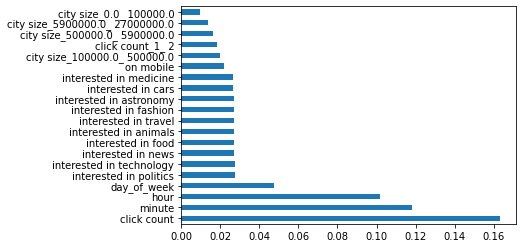

In [41]:
# Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns.values)
feature_importances.nlargest(20).plot(kind='barh')

In [42]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# # define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=42)

In [43]:
# y.value_counts()[0] / y.value_counts()[1]

In [44]:
# weights = [
#     y.value_counts()[0] / y.value_counts()[1],
#     25,
#     50,
#     99,
#     1000,
#     9999,
#     9999999,
# ]
# param_grid = dict(scale_pos_weight=weights)
# grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=999)

In [45]:
# # # # execute the grid search
# grid_result = grid.fit(X, y)
# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [46]:
# evaluate model
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [47]:
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.89545


/home/faqster/projects/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


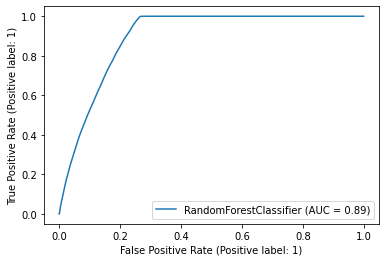

In [48]:
metrics.plot_roc_curve(clf, X_test, y_test) 

In [49]:
train_df.value_counts("User Id").shape[0]/train_df.shape[0]

0.3462234415874434

In [50]:
train_df.value_counts("User Id")

User Id
658554    232
297960    191
983136    160
422201    150
929999    135
         ... 
559973      1
559972      1
110646      1
559957      1
4           1
Length: 135659, dtype: int64

In [51]:
train_df[train_df["Clicked"] == "Yes"].value_counts("User Id")

User Id
252158     15
357044     13
222506     12
394410     10
40010      10
           ..
378181      1
378115      1
378085      1
378076      1
1141723     1
Length: 22118, dtype: int64

In [52]:
train_df.value_counts("User Id").mean(), train_df.value_counts("User Id").std()

(2.8883081844919984, 4.857593776096582)

In [53]:
test_df.value_counts("User Id")

User Id
678048     65
577452     48
246571     39
728477     37
378888     37
           ..
427932      1
427815      1
427806      1
427659      1
1141716     1
Length: 38590, dtype: int64

In [54]:
test_df.value_counts("User Id").mean(), test_df.value_counts("User Id").std()

(1.8519305519564655, 2.0090103286329875)

In [55]:
train_df[train_df["User Id"] == 658554]

,Session Id,DateTime,User Id,Product Type,Campaign Id,Webpage Id,Product Category,Advertisment Size,User Depth,Internet Browser Id,Gender,Age Group,City Size,Device Used,Clicked,Interested In Cars,Interested In Food,Interested In News,Interested In Technology,Interested In Medicine,Interested In Politics,Interested In Fashion,Interested In Astronomy,Interested In Animals,Interested In Travel
6720,40f389d4-0af3-4e70-90d3-49eea04cb272,09-04-2021 06:12,658554,I,360936,13787,2,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,1,0,0,1,1,0,0,0,1,0
6721,648d3377-1ec9-49d6-bb61-7acfd6d3513a,09-04-2021 06:12,658554,I,414149,45962,3,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,1,0,1,0,1,0,1,1,1,1
6747,c7c7d0ae-39e0-4aa7-8eba-6cb426f4bc02,09-04-2021 06:13,658554,G,414149,45962,2,254132.0,2.0,4.0,M,45-54,NaN,Mobile,No,0,0,1,1,1,0,1,0,1,0
6748,9c78a03e-24c5-4f9f-b223-6441b133b628,09-04-2021 06:13,658554,H,360936,13787,4,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,0,0,0,1,0,0,0,0,1,0
6750,03595e62-02c6-4829-bf38-29112571e3c2,09-04-2021 06:13,658554,I,404347,53587,1,146115.0,2.0,4.0,M,45-54,NaN,Mobile,No,1,1,0,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363077,810903fe-f6fc-437b-a618-af2876aa7266,13-04-2021 15:54,658554,H,359520,13787,4,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,1,0,0,0,0,0,1,0,1,0
377053,b21f4bef-8700-4ca3-932c-f0ddf9fcd280,13-04-2021 18:57,658554,D,359520,13787,4,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,1,1,1,1,1,0,1,1,0,0
387087,8ac2021d-09b1-45f4-be15-7fd50b08f835,13-04-2021 21:15,658554,E,98970,6970,2,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,1,0,1,0,1,0,1,0,0,1
387172,b8448ddb-5923-4cdf-adb7-eb6f6b84a7f9,13-04-2021 21:15,658554,H,359520,13787,3,NaN,2.0,4.0,M,45-54,NaN,Mobile,No,1,0,0,1,1,1,1,1,0,1


In [56]:
train_df["DateTime"] = pd.to_datetime(train_df["DateTime"])
df_ts = train_df.set_index(["User Id", "DateTime"]).sort_index()
df_ts["Clicked"] = df_ts["Clicked"].str.lower().map(dict(yes=1, no=0)).astype(int)

In [57]:
# df_ts_resampled_min = df_ts.groupby('User Id')['Clicked'].resample("D", level=1).sum()  # rolling(min_periods=1, window=3).sum().values

In [58]:
# train_df.merge(train_df.groupby("User Id")["Clicked"].sum().rename('Click Count'), how = 'inner', on = ['User Id']).max()["Click Count"]

In [59]:
# df_ts['sum'] = df.groupby('id')['val'].rolling(min_periods=1, window=3).sum().values

In [60]:
# df_ts_resampled_min.count(level=0)

In [61]:
# train_df.groupby("User Id")["Clicked"].sum()

In [62]:
X_train

,interested in cars,interested in food,interested in news,interested in technology,interested in medicine,interested in politics,interested in fashion,interested in astronomy,interested in animals,interested in travel,hour,minute,day_of_week,gender_f,gender_m,age group_18-24,age group_25-34,age group_35-44,age group_45-54,age group_55-64,age group_lt18,age group_gt65,on mobile,product_category_1,product_category_2,product_category_3,product_category_4,product_category_5,product_type_a,product_type_b,product_type_c,product_type_d,product_type_e,product_type_f,product_type_g,product_type_h,product_type_i,product_type_j,internet_browser_id_0.0,internet_browser_id_1.0,internet_browser_id_2.0,internet_browser_id_3.0,internet_browser_id_4.0,internet_browser_id_5.0,internet_browser_id_6.0,internet_browser_id_7.0,internet_browser_id_8.0,internet_browser_id_9.0,internet_browser_id_10.0,internet_browser_id_11.0,internet_browser_id_12.0,user depth_1.0,user depth_2.0,user depth_3.0,city size_0.0_ 100000.0,city size_100000.0_ 500000.0,city size_500000.0_ 5900000.0,city size_5900000.0_ 27000000.0,advertisment size_0_ 100000,advertisment size_100000_ 200000,advertisment size_200000_ 300000,advertisment size_300000_ 400000,click count,click count_1_ 2,click count_2_ 3,click count_3_ 4,click count_4_ 5,click count_5_ 6,click count_6_ 7,click count_7_ 8,click count_8_ 9,click count_9_ 10,click count_10_ 11,click count_11_ 12,click count_12_ 13,click count_13_ 14,click count_14_ 15,click count_15_ 16
3963,1,1,0,1,1,1,0,0,1,0,4,44,1.000000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69044,0,0,1,0,0,0,1,1,0,1,9,50,0.666667,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15208,0,0,0,0,1,0,0,1,0,1,7,10,0.166667,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.133333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33118,1,0,1,0,1,0,0,0,0,1,15,45,0.166667,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313140,0,0,0,1,0,1,1,0,1,0,17,45,1.000000,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.066667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210104,1,1,1,1,0,1,0,1,1,1,7,26,0.833333,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.066667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
299286,0,1,0,0,0,0,1,1,0,0,17,34,0.000000,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.066667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25015,0,0,1,1,1,0,0,0,0,0,6,18,0.666667,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.066667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
140890,1,0,0,1,1,0,1,1,0,1,10,4,1.000000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
